#  [FastComposer: Tuning-Free Multi-Subject Image Generation with Localized Attention](https://fastcomposer.mit.edu/)

FastComposer uses subject embeddings extracted by an image encoder to augment the generic text conditioning in diffusion models, enabling personalized image generation based on subject images and textual instructions with only forward passes.
Moreover it addresses two problems:

 - **The identity blending problem.**
To address the problem in the multi-subject generation it proposes cross-attention localization supervision during training, enforcing the attention of reference subjects localized to the correct regions in the target images.

 - **Subject overfitting.**
Naively conditioning on subject embeddings results in subject overfitting. FastComposer proposes delayed subject conditioning in the denoising step to maintain both identity and editability in subject-driven image generation.


FastComposer generates images of multiple unseen individuals with different styles, actions, and contexts.


<img src="https://github.com/mit-han-lab/fastcomposer/blob/main/figures/multi-subject.png?raw=True" width="969">


> **NOTE**: `model.py` is slightly changed `model.py` from fastcomposer repository. There are two main changes:
>  - some unused lines of code are removed to avoid errors if there are no CUDA drivers in the system
>  - changes to have compatibility with transformers >= 4.30.1 (due to security vulnerability)


#### Table of contents:
- [Install Prerequisites](#Install-Prerequisites)
- [Convert models to OpenVINO Intermediate representation (IR) format](#Convert-models-to-OpenVINO-Intermediate-representation-(IR)-format)
    - [Convert text_encoder](#Convert-text_encoder)
    - [The Object Transform](#The-Object-Transform)
    - [The Image Encoder](#The-Image-Encoder)
    - [Postfuse module](#Postfuse-module)
    - [Convert Unet](#Convert-Unet)
- [Rebuild pipeline](#Rebuild-pipeline)
- [Inference](#Inference)
- [Run Gradio](#Run-Gradio)


<div class="alert alert-block alert-warning">
    This tutorial requires about 25-28GB of free memory to generate one image. Each extra image requires ~11GB of free memory.
</div>

## Install Prerequisites
[back to top ⬆️](#Table-of-contents:)
Install required packages.

In [ ]:
%pip install -q --upgrade pip
%pip install -q --extra-index-url https://download.pytorch.org/whl/cpu torch torchvision
%pip install -q transformers  huggingface-hub accelerate "diffusers>=0.16.1" gradio
%pip install -q "openvino>=2023.1.0"

Clone FastComposer project from GitHub

In [1]:
from pathlib import Path


# clone FastComposer repo
if not Path("fastcomposer").exists():
    !git clone https://github.com/mit-han-lab/fastcomposer.git
else:
    print("FastComposer repo already cloned")

Cloning into 'fastcomposer'...
remote: Enumerating objects: 339, done.
remote: Counting objects: 100% (276/276), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 339 (delta 170), reused 231 (delta 142), pack-reused 63
Receiving objects: 100% (339/339), 35.12 MiB | 13.94 MiB/s, done.
Resolving deltas: 100% (186/186), done.


Download pretrained model.

In [2]:
from huggingface_hub import hf_hub_download


model_path = hf_hub_download(repo_id='mit-han-lab/fastcomposer', filename='pytorch_model.bin')

## Convert models to OpenVINO Intermediate representation (IR) format
[back to top ⬆️](#Table-of-contents:)

Define a configuration and make instance of `FastComposerModel`.

In [3]:
from dataclasses import dataclass

import torch


@dataclass()
class Config:
    finetuned_model_path = str(model_path)
    image_encoder_name_or_path = 'openai/clip-vit-large-patch14'
    localization_layers = 5
    mask_loss = False
    mask_loss_prob = 0.5
    non_ema_revision = None
    object_localization = False
    object_localization_weight = 0.01
    object_resolution = 256
    pretrained_model_name_or_path = 'runwayml/stable-diffusion-v1-5'
    revision = None


config = Config()
model = FastComposerModel.from_pretrained(config)
model.load_state_dict(torch.load(config.finetuned_model_path, map_location="cpu"), strict=False)

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


_IncompatibleKeys(missing_keys=['vae.encoder.mid_block.attentions.0.to_q.weight', 'vae.encoder.mid_block.attentions.0.to_q.bias', 'vae.encoder.mid_block.attentions.0.to_k.weight', 'vae.encoder.mid_block.attentions.0.to_k.bias', 'vae.encoder.mid_block.attentions.0.to_v.weight', 'vae.encoder.mid_block.attentions.0.to_v.bias', 'vae.encoder.mid_block.attentions.0.to_out.0.weight', 'vae.encoder.mid_block.attentions.0.to_out.0.bias', 'vae.decoder.mid_block.attentions.0.to_q.weight', 'vae.decoder.mid_block.attentions.0.to_q.bias', 'vae.decoder.mid_block.attentions.0.to_k.weight', 'vae.decoder.mid_block.attentions.0.to_k.bias', 'vae.decoder.mid_block.attentions.0.to_v.weight', 'vae.decoder.mid_block.attentions.0.to_v.bias', 'vae.decoder.mid_block.attentions.0.to_out.0.weight', 'vae.decoder.mid_block.attentions.0.to_out.0.bias'], unexpected_keys=['text_encoder.embeddings.position_ids', 'image_encoder.vision_model.embeddings.position_ids', 'vae.encoder.mid_block.attentions.0.query.weight', 'vae.

Pipeline consist of next models: `Unet`, `TextEncoder`, `ImageEncoder` and `PostfuseModule` (MLP), `object_transforms` . 


![inference-pipeline](https://github.com/openvinotoolkit/openvino_notebooks/assets/29454499/1d858a65-e7c7-43f8-83df-1e896d745725)


So, convert the models into OpenVINO IR format.

### Convert text_encoder
[back to top ⬆️](#Table-of-contents:)

Model components are PyTorch modules, that can be converted with openvino.convert_model function directly. We also use openvino.save_model function to serialize the result of conversion. Let's create a helper function.

In [4]:
import gc
import openvino


def convert(model: torch.nn.Module, xml_path: str, example_input):
    xml_path = Path(xml_path)
    if not xml_path.exists():
        xml_path.parent.mkdir(parents=True, exist_ok=True)
        with torch.no_grad():
            converted_model = openvino.convert_model(model, example_input=example_input)
        openvino.save_model(converted_model, xml_path)
        
        # cleanup memory
        torch._C._jit_clear_class_registry()
        torch.jit._recursive.concrete_type_store = torch.jit._recursive.ConcreteTypeStore()
        torch.jit._state._clear_class_state()

The text encoder is responsible for converting the input prompt into an embedding space that can be fed to the next stage's U-Net. Typically, it is a transformer-based encoder that maps a sequence of input tokens to a sequence of text embeddings.

The input for the text encoder consists of a tensor `input_ids`, which contains token indices from the text processed by the tokenizer and padded to the maximum length accepted by the model.

In [5]:
text_encoder_ir_xml_path = Path('models/text_encoder_ir.xml')
example_input = torch.zeros((1, 77), dtype=torch.int64)

model.text_encoder.eval()
convert(model.text_encoder, text_encoder_ir_xml_path, example_input)

del model.text_encoder
gc.collect();

/home/ea/work/genai_env/lib/python3.8/site-packages/transformers/models/clip/modeling_clip.py:273: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if attn_weights.size() != (bsz * self.num_heads, tgt_len, src_len):
/home/ea/work/genai_env/lib/python3.8/site-packages/transformers/models/clip/modeling_clip.py:281: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if causal_attention_mask.size() != (bsz, 1, tgt_len, src_len):
/home/ea/work/genai_env/lib/python3.8/site-packages/transformers/models/clip/modeling_clip.py:313: TracerWarning: Converting a tensor to 

### The Object Transform
[back to top ⬆️](#Table-of-contents:)

It pads an incoming user image to square and resize it. An input is a tensor of size [3, height, width].

In [6]:
from collections import OrderedDict
from torchvision import transforms as T
from fastcomposer.fastcomposer.transforms import PadToSquare


object_transforms = torch.nn.Sequential(
    OrderedDict(
        [
            ("pad_to_square", PadToSquare(fill=0, padding_mode="constant")),
            (
                "resize",
                T.Resize(
                    (config.object_resolution, config.object_resolution),
                    interpolation=T.InterpolationMode.BILINEAR,
                    antialias=True,
                ),
            ),
            ("convert_to_float", T.ConvertImageDtype(torch.float32)),
        ]
    )
)

object_transforms_ir_xml_path = Path('models/object_transforms_ir.xml')
example_input = torch.zeros([3, 1500, 1453], dtype=torch.uint8)

object_transforms.eval()
convert(object_transforms, object_transforms_ir_xml_path, example_input)

del object_transforms
gc.collect();

0


/home/ea/work/openvino_notebooks/notebooks/252-fastcomposer-image-generation/fastcomposer/fastcomposer/transforms.py:35: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if h == w:
/home/ea/work/openvino_notebooks/notebooks/252-fastcomposer-image-generation/fastcomposer/fastcomposer/transforms.py:37: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  elif h > w:


### The Image Encoder
[back to top ⬆️](#Table-of-contents:)

The image encoder is a CLIP (Contrastive Language-Image Pretraining) Image Encoder. It takes a transformed image from the previous step as input and transforms it into a high-dimensional vector or embeddings.

In [7]:
image_encoder_ir_xml_path = Path('models/image_encoder_ir.xml')
example_input = torch.zeros((1, 2, 3, 256, 256), dtype=torch.float32)

model.image_encoder.eval()
convert(model.image_encoder, image_encoder_ir_xml_path, example_input)

del model.image_encoder
gc.collect();

/home/ea/work/openvino_notebooks/notebooks/252-fastcomposer-image-generation/model.py:108: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if h != self.image_size or w != self.image_size:


### Postfuse module
[back to top ⬆️](#Table-of-contents:)

On this step it is employed a multilayer perceptron (MLP) to augment the text embeddings with visual features extracted from the reference subjects. The Postfuse module concatenates the word embeddings with the visual features and feeds the resulting augmented embeddings into the MLP.

In [8]:
postfuse_module_ir_xml_path = Path('models/postfuse_module_ir.xml')

example_input = [
    torch.zeros((1, 77, 768), dtype=torch.float32),
    torch.zeros((1, 2, 1, 768), dtype=torch.float32),
    torch.zeros((1, 77), dtype=torch.bool),
    torch.zeros((1,), dtype=torch.int64)
]

model.postfuse_module.eval()
convert(model.postfuse_module, postfuse_module_ir_xml_path, example_input)

del model.postfuse_module
gc.collect();

### Convert Unet
[back to top ⬆️](#Table-of-contents:)

U-Net model gradually denoises latent image representation guided by text encoder hidden state.

In [9]:
unet_ir_xml_path = Path('models/unet_ir.xml')

example_input = [
    torch.zeros((8, 4, 64, 64), dtype=torch.float32),
    torch.zeros((), dtype=torch.int64),
    torch.zeros((8, 77, 768), dtype=torch.float32)
]
model.unet.eval()
convert(model.unet, unet_ir_xml_path, example_input)


del model
del example_input

gc.collect()

/home/ea/work/genai_env/lib/python3.8/site-packages/diffusers/models/unet_2d_condition.py:878: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if dim % default_overall_up_factor != 0:
/home/ea/work/genai_env/lib/python3.8/site-packages/peft/tuners/loha/layer.py:270: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  def forward(ctx, w1a, w1b, w2a, w2b, scale=torch.tensor(1)):
/home/ea/work/genai_env/lib/python3.8/site-packages/peft/tuners/loha/layer.py:293: TracerWarning: torch.tensor results are registered as constants i

16724

## Rebuild pipeline
[back to top ⬆️](#Table-of-contents:)

Also, it needs to modify some internal FastComposer entities, to use OpenVINO models. First of all, how to get results. For example, to convert outputs from numpy to torch types.

In [19]:
import numpy as np
from diffusers.pipelines.stable_diffusion import StableDiffusionPipelineOutput
from diffusers.pipelines.stable_diffusion import StableDiffusionPipeline
from diffusers.loaders import TextualInversionLoaderMixin
from typing import Any, Callable, Dict, List, Optional, Union
from PIL import Image


class StableDiffusionFastCompposerPipeline(StableDiffusionPipeline):
    r"""
    Pipeline for text-to-image generation using FastComposer (https://arxiv.org/abs/2305.10431).

    This model inherits from [`StableDiffusionPipeline`]. Check the superclass documentation for the generic methods the
    library implements for all the pipelines (such as downloading or saving, running on a particular device, etc.)
    """


    @torch.no_grad()
    def _tokenize_and_mask_noun_phrases_ends(self, caption):
        input_ids = self.special_tokenizer.encode(caption)
        noun_phrase_end_mask = [False for _ in input_ids]
        clean_input_ids = []
        clean_index = 0

        for i, id in enumerate(input_ids):
            if id == self.image_token_id:
                noun_phrase_end_mask[clean_index - 1] = True
            else:
                clean_input_ids.append(id)
                clean_index += 1

        max_len = self.special_tokenizer.model_max_length

        if len(clean_input_ids) > max_len:
            clean_input_ids = clean_input_ids[:max_len]
        else:
            clean_input_ids = clean_input_ids + [self.tokenizer.pad_token_id] * (
                max_len - len(clean_input_ids)
            )

        if len(noun_phrase_end_mask) > max_len:
            noun_phrase_end_mask = noun_phrase_end_mask[:max_len]
        else:
            noun_phrase_end_mask = noun_phrase_end_mask + [False] * (
                max_len - len(noun_phrase_end_mask)
            )

        clean_input_ids = torch.tensor(clean_input_ids, dtype=torch.long)
        noun_phrase_end_mask = torch.tensor(noun_phrase_end_mask, dtype=torch.bool)
        return clean_input_ids.unsqueeze(0), noun_phrase_end_mask.unsqueeze(0)

    @torch.no_grad()
    def _encode_augmented_prompt(self, prompt: str, reference_images: List[Image.Image], device: torch.device, weight_dtype: torch.dtype):
        # TODO: check this
        # encode reference images
        object_pixel_values = []
        for image in reference_images:
            image_tensor = torch.from_numpy(np.array(image.convert("RGB"))).permute(2, 0, 1)
            image = torch.from_numpy((self.object_transforms(image_tensor)[0]))
            object_pixel_values.append(image)

        object_pixel_values = torch.stack(object_pixel_values, dim=0).to(memory_format=torch.contiguous_format).float()
        object_pixel_values = object_pixel_values.unsqueeze(0).to(dtype=torch.float32, device=device)
        object_embeds = self.image_encoder(object_pixel_values)[0]
        object_embeds = torch.from_numpy(object_embeds)

        # augment the text embedding
        input_ids, image_token_mask = self._tokenize_and_mask_noun_phrases_ends(prompt)
        input_ids, image_token_mask = input_ids.to(device), image_token_mask.to(device)

        num_objects = image_token_mask.sum(dim=1)

        text_embeds = torch.from_numpy(self.text_encoder(input_ids)[0])
        augmented_prompt_embeds = self.postfuse_module([
            text_embeds,
            object_embeds,
            image_token_mask,
            num_objects
        ])[0]
        return torch.from_numpy(augmented_prompt_embeds)

    def _encode_prompt(
        self,
        prompt,
        device,
        num_images_per_prompt,
        do_classifier_free_guidance,
        negative_prompt=None
    ):
        r"""
        Encodes the prompt into text encoder hidden states.

        Args:
             prompt (`str` or `List[str]`, *optional*):
                prompt to be encoded
            device: (`torch.device`):
                torch device
            num_images_per_prompt (`int`):
                number of images that should be generated per prompt
            do_classifier_free_guidance (`bool`):
                whether to use classifier free guidance or not
            negative_prompt (`str` or `List[str]`, *optional*):
                The prompt or prompts not to guide the image generation. If not defined, one has to pass
                `negative_prompt_embeds` instead. Ignored when not using guidance (i.e., ignored if `guidance_scale` is
                less than `1`).
        """
        if isinstance(prompt, str):
            batch_size = 1
        elif isinstance(prompt, list):
            batch_size = len(prompt)

        # textual inversion: procecss multi-vector tokens if necessary
        if isinstance(self, TextualInversionLoaderMixin):
            prompt = self.maybe_convert_prompt(prompt, self.tokenizer)

        text_inputs = self.tokenizer(
            prompt,
            padding="max_length",
            max_length=self.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        )
        text_input_ids = text_inputs.input_ids
        untruncated_ids = self.tokenizer(prompt, padding="longest", return_tensors="pt").input_ids

        if untruncated_ids.shape[-1] >= text_input_ids.shape[-1] and not torch.equal(
            text_input_ids, untruncated_ids
        ):
            removed_text = self.tokenizer.batch_decode(
                untruncated_ids[:, self.tokenizer.model_max_length - 1 : -1]
            )
            print(
                "The following part of your input was truncated because CLIP can only handle sequences up to"
                f" {self.tokenizer.model_max_length} tokens: {removed_text}"
            )

        prompt_embeds = self.text_encoder(text_input_ids.to(device))[0]
        prompt_embeds = torch.from_numpy(prompt_embeds)

        bs_embed, seq_len, _ = prompt_embeds.shape
        # duplicate text embeddings for each generation per prompt, using mps friendly method
        prompt_embeds = prompt_embeds.repeat(1, num_images_per_prompt, 1)
        prompt_embeds = prompt_embeds.view(bs_embed * num_images_per_prompt, seq_len, -1)

        # get unconditional embeddings for classifier free guidance
        if do_classifier_free_guidance:
            uncond_tokens: List[str]
            if negative_prompt is None:
                uncond_tokens = [""] * batch_size
            elif type(prompt) is not type(negative_prompt):
                raise TypeError(
                    f"`negative_prompt` should be the same type to `prompt`, but got {type(negative_prompt)} !="
                    f" {type(prompt)}."
                )
            elif isinstance(negative_prompt, str):
                uncond_tokens = [negative_prompt]
            elif batch_size != len(negative_prompt):
                raise ValueError(
                    f"`negative_prompt`: {negative_prompt} has batch size {len(negative_prompt)}, but `prompt`:"
                    f" {prompt} has batch size {batch_size}. Please make sure that passed `negative_prompt` matches"
                    " the batch size of `prompt`."
                )
            else:
                uncond_tokens = negative_prompt

            # textual inversion: procecss multi-vector tokens if necessary
            if isinstance(self, TextualInversionLoaderMixin):
                uncond_tokens = self.maybe_convert_prompt(uncond_tokens, self.tokenizer)

            max_length = prompt_embeds.shape[1]
            uncond_input = self.tokenizer(
                uncond_tokens,
                padding="max_length",
                max_length=max_length,
                truncation=True,
                return_tensors="pt",
            )

            negative_prompt_embeds = self.text_encoder(uncond_input.input_ids.to(device))[0]
            negative_prompt_embeds = torch.from_numpy(negative_prompt_embeds)

        if do_classifier_free_guidance:
            # duplicate unconditional embeddings for each generation per prompt, using mps friendly method
            seq_len = negative_prompt_embeds.shape[1]

            negative_prompt_embeds = negative_prompt_embeds.to(dtype=torch.float32, device=device)

            negative_prompt_embeds = negative_prompt_embeds.repeat(1, num_images_per_prompt, 1)
            negative_prompt_embeds = negative_prompt_embeds.view(batch_size * num_images_per_prompt, seq_len, -1)

            # For classifier free guidance, we need to do two forward passes.
            # Here we concatenate the unconditional and text embeddings into a single batch
            # to avoid doing two forward passes
            prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds])

        return prompt_embeds


    @torch.no_grad()
    def __call__(
        self,
        prompt: Union[str, List[str]] = None,
        height: Optional[int] = None,
        width: Optional[int] = None,
        num_inference_steps: int = 50,
        guidance_scale: float = 7.5,
        negative_prompt: Optional[Union[str, List[str]]] = None,
        num_images_per_prompt: Optional[int] = 1,
        eta: float = 0.0,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        latents: Optional[torch.FloatTensor] = None,
        prompt_embeds: Optional[torch.FloatTensor] = None,
        negative_prompt_embeds: Optional[torch.FloatTensor] = None,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
        callback: Optional[Callable[[int, int, torch.FloatTensor], None]] = None,
        callback_steps: int = 1,
        cross_attention_kwargs: Optional[Dict[str, Any]] = None,
        alpha_: float = 0.7,
        reference_subject_images: List[Image.Image] = None,
        augmented_prompt_embeds: Optional[torch.FloatTensor] = None
    ):
        r"""
        Function invoked when calling the pipeline for generation.

        Args:
            prompt (`str` or `List[str]`, *optional*):
                The prompt or prompts to guide the image generation. If not defined, one has to pass `prompt_embeds`.
                instead.
            height (`int`, *optional*, defaults to self.unet.config.sample_size * self.vae_scale_factor):
                The height in pixels of the generated image.
            width (`int`, *optional*, defaults to self.unet.config.sample_size * self.vae_scale_factor):
                The width in pixels of the generated image.
            num_inference_steps (`int`, *optional*, defaults to 50):
                The number of denoising steps. More denoising steps usually lead to a higher quality image at the
                expense of slower inference.
            guidance_scale (`float`, *optional*, defaults to 7.5):
                Guidance scale as defined in [Classifier-Free Diffusion Guidance](https://arxiv.org/abs/2207.12598).
                `guidance_scale` is defined as `w` of equation 2. of [Imagen
                Paper](https://arxiv.org/pdf/2205.11487.pdf). Guidance scale is enabled by setting `guidance_scale >
                1`. Higher guidance scale encourages to generate images that are closely linked to the text `prompt`,
                usually at the expense of lower image quality.
            negative_prompt (`str` or `List[str]`, *optional*):
                The prompt or prompts not to guide the image generation. If not defined, one has to pass
                `negative_prompt_embeds` instead. Ignored when not using guidance (i.e., ignored if `guidance_scale` is
                less than `1`).
            num_images_per_prompt (`int`, *optional*, defaults to 1):_unwrap_model
                The number of images to generate per prompt.
            eta (`float`, *optional*, defaults to 0.0):
                Corresponds to parameter eta (η) in the DDIM paper: https://arxiv.org/abs/2010.02502. Only applies to
                [`schedulers.DDIMScheduler`], will be ignored for others.
            generator (`torch.Generator` or `List[torch.Generator]`, *optional*):
                One or a list of [torch generator(s)](https://pytorch.org/docs/stable/generated/torch.Generator.html)
                to make generation deterministic.
            latents (`torch.FloatTensor`, *optional*):
                Pre-generated noisy latents, sampled from a Gaussian distribution, to be used as inputs for image
                generation. Can be used to tweak the same generation with different prompts. If not provided, a latents
                tensor will ge generated by sampling using the supplied random `generator`.
            prompt_embeds (`torch.FloatTensor`, *optional*):
                Pre-generated text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt weighting. If not
                provided, text embeddings will be generated from `prompt` input argument.
            negative_prompt_embeds (`torch.FloatTensor`, *optional*):
                Pre-generated negative text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt
                weighting. If not provided, negative_prompt_embeds will be generated from `negative_prompt` input
                argument.
            output_type (`str`, *optional*, defaults to `"pil"`):
                The output format of the generate image. Choose between
                [PIL](https://pillow.readthedocs.io/en/stable/): `PIL.Image.Image` or `np.array`.
            return_dict (`bool`, *optional*, defaults to `True`):
                Whether or not to return a [`~pipelines.stable_diffusion.StableDiffusionPipelineOutput`] instead of a
                plain tuple.
            callback (`Callable`, *optional*):
                A function that will be called every `callback_steps` steps during inference. The function will be
                called with the following arguments: `callback(step: int, timestep: int, latents: torch.FloatTensor)`.
            callback_steps (`int`, *optional*, defaults to 1):
                The frequency at which the `callback` function will be called. If not specified, the callback will be
                called at every step.
            cross_attention_kwargs (`dict`, *optional*):
                A kwargs dictionary that if specified is passed along to the `AttentionProcessor` as defined under
                `self.processor` in
                [diffusers.cross_attention](https://github.com/huggingface/diffusers/blob/main/src/diffusers/models/cross_attention.py).
            alpha_ (`float`, defaults to 0.7):
                The ratio of subject conditioning. If `alpha_` is 0.7, the beginning 30% of denoising steps use text prompts, while the
                last 70% utilize image-augmented prompts. Increase alpha for identity preservation, decrease it for prompt consistency.
            reference_subject_images (`List[PIL.Image.Image]`):
                a list of PIL images that are used as reference subjects. The number of images should be equal to the number of augmented
                tokens in the prompts.
            augmented_prompt_embeds: (`torch.FloatTensor`, *optional*):
                Pre-generated image augmented text embeddings. If not provided, embeddings will be generated from `prompt` and
                `reference_subject_images`.
        Examples:

        Returns:
            [`~pipelines.stable_diffusion.StableDiffusionPipelineOutput`] or `tuple`:
            [`~pipelines.stable_diffusion.StableDiffusionPipelineOutput`] if `return_dict` is True, otherwise a `tuple.
            When returning a tuple, the first element is a list with the generated images, and the second element is a
            list of `bool`s denoting whether the corresponding generated image likely represents "not-safe-for-work"
            (nsfw) content, according to the `safety_checker`.
        """
        # 0. Default height and width to unet
        height = height or self.unet.config.sample_size * self.vae_scale_factor
        width = width or self.unet.config.sample_size * self.vae_scale_factor

        # 1. Check inputs. Raise error if not correct
        self.check_inputs(
            prompt,
            height,
            width,
            callback_steps,
            negative_prompt,
            prompt_embeds,
            negative_prompt_embeds,
        )

        assert (prompt is not None and reference_subject_images is not None) or (prompt_embeds is not None and augmented_prompt_embeds is not None),  \
            "Prompt and reference subject images or prompt_embeds and augmented_prompt_embeds must be provided."

        # 2. Define call parameters
        if prompt is not None and isinstance(prompt, str):
            batch_size = 1
        elif prompt is not None and isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            batch_size = prompt_embeds.shape[0]

        device = self._execution_device
        # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
        # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
        # corresponds to doing no classifier free guidance.
        do_classifier_free_guidance = guidance_scale > 1.0

        assert do_classifier_free_guidance

        # 3. Encode input prompt
        prompt_text_only = prompt.replace("<image>", "")

        prompt_embeds = self._encode_prompt(
            prompt_text_only,
            device,
            num_images_per_prompt,
            do_classifier_free_guidance,
            negative_prompt,
        )

        if augmented_prompt_embeds is None:
            augmented_prompt_embeds = self._encode_augmented_prompt(prompt, reference_subject_images, device, prompt_embeds.dtype)
            augmented_prompt_embeds = augmented_prompt_embeds.repeat(num_images_per_prompt, 1, 1)

        prompt_embeds = torch.cat([prompt_embeds, augmented_prompt_embeds], dim=0)

        # 4. Prepare timesteps
        self.scheduler.set_timesteps(num_inference_steps, device=device)
        timesteps = self.scheduler.timesteps

        # 5. Prepare latent variables
        # num_channels_latents = self.unet.in_channels
        num_channels_latents = 4
        latents = self.prepare_latents(
            batch_size * num_images_per_prompt,
            num_channels_latents,
            height,
            width,
            prompt_embeds.dtype,
            device,
            generator,
            latents,
        )

        start_subject_conditioning_step = (1 - alpha_) * num_inference_steps

        extra_step_kwargs = self.prepare_extra_step_kwargs(generator, eta)
        (
            null_prompt_embeds,
            text_prompt_embeds,
            augmented_prompt_embeds
        ) = prompt_embeds.chunk(3)

        # 7. Denoising loop
        num_warmup_steps = len(timesteps) - num_inference_steps * self.scheduler.order
        with self.progress_bar(total=num_inference_steps) as progress_bar:
            for i, t in enumerate(timesteps):
                latent_model_input = (
                    torch.cat([latents] * 2) if do_classifier_free_guidance else latents
                )
                latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

                if i <= start_subject_conditioning_step:
                    current_prompt_embeds = torch.cat(
                        [null_prompt_embeds, text_prompt_embeds], dim=0
                    )
                else:
                    current_prompt_embeds = torch.cat(
                        [null_prompt_embeds, augmented_prompt_embeds], dim=0
                    )

                # predict the noise residual
                noise_pred = self.unet([
                    latent_model_input,
                    t,
                    current_prompt_embeds,
                    # cross_attention_kwargs
                ],
                )[0]
                noise_pred = torch.from_numpy(noise_pred)


                # perform guidance
                if do_classifier_free_guidance:
                    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                    noise_pred = noise_pred_uncond + guidance_scale * (
                        noise_pred_text - noise_pred_uncond
                    )
                else:
                    assert 0, "Not Implemented"

                # compute the previous noisy sample x_t -> x_t-1
                latents = self.scheduler.step(
                    noise_pred, t, latents, **extra_step_kwargs
                ).prev_sample

                # call the callback, if provided
                if i == len(timesteps) - 1 or (
                    (i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0
                ):
                    progress_bar.update()
                    if callback is not None and i % callback_steps == 0:
                        callback(i, t, latents)

        if output_type == "latent":
            image = latents
            has_nsfw_concept = None
        elif output_type == "pil":
            # 8. Post-processing
            image = self.decode_latents(latents)

            # 9. Run safety checker
            image, has_nsfw_concept = self.run_safety_checker(
                image, device, prompt_embeds.dtype
            )

            # 10. Convert to PIL
            image = self.numpy_to_pil(image)
        else:
            # 8. Post-processing
            image = self.decode_latents(latents)

            # 9. Run safety checker
            image, has_nsfw_concept = self.run_safety_checker(
                image, device, prompt_embeds.dtype
            )

        # Offload last model to CPU
        if hasattr(self, "final_offload_hook") and self.final_offload_hook is not None:
            self.final_offload_hook.offload()

        if not return_dict:
            return (image, has_nsfw_concept)

        return StableDiffusionPipelineOutput(
            images=image, nsfw_content_detected=has_nsfw_concept
        )

And replace all model in the pipeline by converted models.

In [20]:
import PIL
from transformers import CLIPTokenizer


def create_pipeline(
        args,
        *,
        text_encoder,
        image_encoder,
        unet,
        object_transforms,
        postfuse_module,
        device
):
    weight_dtype = torch.float32

    tokenizer = CLIPTokenizer.from_pretrained(
        args.pretrained_model_name_or_path,
        subfolder="tokenizer",
        revision=args.revision,
    )
    tokenizer.add_tokens(["img"], special_tokens=True)
    image_token_id = tokenizer.convert_tokens_to_ids("img")

    pipe = StableDiffusionFastCompposerPipeline.from_pretrained(
        args.pretrained_model_name_or_path, torch_dtype=weight_dtype
    ).to(device)

    pipe.object_transforms = object_transforms
    pipe.unet = unet
    pipe.text_encoder = text_encoder
    pipe.postfuse_module = postfuse_module
    pipe.image_encoder = image_encoder
    pipe.image_token_id = image_token_id
    pipe.special_tokenizer = tokenizer

    return pipe


class ModelWrapper:
    def __init__(self, model):
        super().__init__()
        self.model = model

    def inference(
        self,
        image1: PIL.Image.Image,
        image2: PIL.Image.Image,
        prompt: str,
        negative_prompt: str,
        seed: int,
        guidance_scale: float,
        alpha_: float,
        num_steps: int,
        num_images: int,
    ):
        print("Running model inference...")
        image = []
        if image1 is not None:
            image.append(image1)

        if image2 is not None:
            image.append(image2)

        if len(image) == 0:
            return [], "You need to upload at least one image."

        num_subject_in_text = (
            np.array(self.model.special_tokenizer.encode(prompt))
            == self.model.image_token_id
        ).sum()
        if num_subject_in_text != len(image):
            return (
                [],
                f"Number of subjects in the text description doesn't match the number of reference images, #text subjects: {num_subject_in_text} #reference image: {len(image)}",
            )

        if seed == -1:
            seed = np.random.randint(0, 1000000)

        generator = torch.manual_seed(seed)

        return (
            self.model(
                prompt=prompt,
                negative_prompt=negative_prompt,
                height=512,
                width=512,
                num_inference_steps=num_steps,
                guidance_scale=guidance_scale,
                num_images_per_prompt=num_images,
                generator=generator,
                alpha_=alpha_,
                reference_subject_images=image,
            ).images,
            "run successfully",
        )


core = openvino.Core()
compiled_unet = core.compile_model(unet_ir_xml_path)
compiled_text_encoder = core.compile_model(text_encoder_ir_xml_path)
compiled_image_encoder = core.compile_model(image_encoder_ir_xml_path)
compiled_postfuse_module = core.compile_model(postfuse_module_ir_xml_path)
compiled_object_transforms = core.compile_model(object_transforms_ir_xml_path)

wrapped_model = ModelWrapper(
    create_pipeline(
        config,
        text_encoder=compiled_text_encoder,
        image_encoder=compiled_image_encoder,
        unet=compiled_unet,
        object_transforms=compiled_object_transforms,
        postfuse_module=compiled_postfuse_module,
        device='cpu'
    )
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


## Inference
[back to top ⬆️](#Table-of-contents:)

And now it is possible to make inference. You can provide 1 or 2 images (`image1` and `image2`). If you want to provide only one image pass in inference `None` instead image. 
`prompt` describes context in what objects from user images will be generated. Word `img` is a token that correlates with input images.  

In [21]:
image1 = Image.open('fastcomposer/data/newton_einstein/einstein/0.png')
image2 = Image.open('fastcomposer/data/newton_einstein/newton/0.png')
prompt = 'A man img and a man img sitting in a park'
negative_prompt = '((((ugly)))), (((duplicate))), ((morbid)), ((mutilated)), [out of frame], extra fingers, mutated hands, ((poorly drawn hands)), ((poorly drawn face)), (((mutation))), (((deformed))), ((ugly)), blurry, ((bad anatomy)), (((bad proportions))), ((extra limbs)), cloned face, (((disfigured))). out of frame, ugly, extra limbs, (bad anatomy), gross proportions, (malformed limbs), ((missing arms)), ((missing legs)), (((extra arms))), (((extra legs))), mutated hands, (fused fingers), (too many fingers), (((long neck)))'
alpha_ = 0.7
num_images = 1  # each extra image requires ~11GB of free memory
num_steps = 50
guidance_scale = 5
seed = -1


result = wrapped_model.inference(
    image1,
    image2,
    prompt,
    negative_prompt,
    seed,
    guidance_scale,
    alpha_,
    num_steps,
    num_images
)

Running model inference...


  0%|          | 0/50 [00:00<?, ?it/s]

/home/ea/work/genai_env/lib/python3.8/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:521: FutureWarning: The decode_latents method is deprecated and will be removed in 1.0.0. Please use VaeImageProcessor.postprocess(...) instead
  deprecate("decode_latents", "1.0.0", deprecation_message, standard_warn=False)


Result consists of several (`num_images`) images and now it possible to display them.

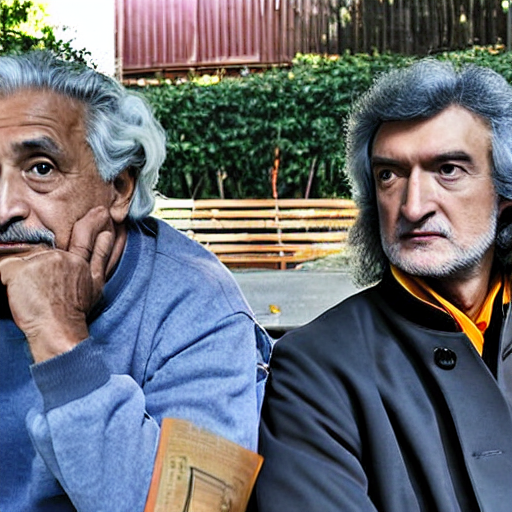

In [22]:
display(result[0][0])

## Run Gradio
[back to top ⬆️](#Table-of-contents:)

Also, it is possible to run with Gradio

In [ ]:
import gradio as gr


def create_demo():
    TITLE = "# [FastComposer Demo](https://github.com/mit-han-lab/fastcomposer) with OpenVINO"

    DESCRIPTION = """To run the demo, you should:
    1. Upload your images. The order of image1 and image2 needs to match the order of the subects in the prompt. You only need 1 image for single subject generation.
    2. Input proper text prompts, such as "A woman img and a man img in the snow" or "A painting of a man img in the style of Van Gogh", where "img" specifies the token you want to augment and comes after the word.
    3. Click the Run button. You can also adjust the hyperparameters to improve the results. Look at the job status to see if there are any errors with your input.
    As a result, pictures with person or persons from input images will be generated in accordance with the description in the prompt.
    """

    with gr.Blocks() as demo:
        gr.Markdown(TITLE)
        gr.Markdown(DESCRIPTION)
        with gr.Row():
            with gr.Column():
                with gr.Group():
                    image1 = gr.Image(label="Image 1", type="pil")
                    gr.Examples(
                        examples=["fastcomposer/data/newton.jpeg"],
                        inputs=image1,
                    )
                    image2 = gr.Image(label="Image 2", type="pil")
                    gr.Examples(
                        examples=["fastcomposer/data/einstein.jpeg"],
                        inputs=image2,
                    )
                    gr.Markdown("Upload the image for your subject")

                prompt = gr.Text(
                    value="A man img and a man img sitting in a park",
                    label="Prompt",
                    placeholder='e.g. "A woman img and a man img in the snow", "A painting of a man img in the style of Van Gogh"',
                    info='Use "img" to specify the word you want to augment.',
                )
                negative_prompt = gr.Text(
                    value="((((ugly)))), (((duplicate))), ((morbid)), ((mutilated)), [out of frame], extra fingers, mutated hands, ((poorly drawn hands)), ((poorly drawn face)), (((mutation))), (((deformed))), ((ugly)), blurry, ((bad anatomy)), (((bad proportions))), ((extra limbs)), cloned face, (((disfigured))). out of frame, ugly, extra limbs, (bad anatomy), gross proportions, (malformed limbs), ((missing arms)), ((missing legs)), (((extra arms))), (((extra legs))), mutated hands, (fused fingers), (too many fingers), (((long neck)))",
                    label="Negative Prompt",
                    info='Features that you want to avoid.',
                )
                alpha_ = gr.Slider(
                    label="alpha",
                    minimum=0,
                    maximum=1,
                    step=0.05,
                    value=0.75,
                    info="A smaller alpha aligns images with text better, but may deviate from the subject image. Increase alpha to improve identity preservation, decrease it for prompt consistency.",
                )
                num_images = gr.Slider(
                    label="Number of generated images",
                    minimum=1,
                    maximum=8,
                    step=1,
                    value=1,
                    info="Each extra image requires ~11GB of free memory.",
                )
                run_button = gr.Button("Run")
                with gr.Accordion(label="Advanced options", open=False):
                    seed = gr.Slider(
                        label="Seed",
                        minimum=-1,
                        maximum=1000000,
                        step=1,
                        value=-1,
                        info="If set to -1, a different seed will be used each time.",
                    )
                    guidance_scale = gr.Slider(
                        label="Guidance scale",
                        minimum=1,
                        maximum=10,
                        step=1,
                        value=5,
                    )
                    num_steps = gr.Slider(
                        label="Steps",
                        minimum=1,
                        maximum=300,
                        step=1,
                        value=50,
                    )
            with gr.Column():
                result = gr.Gallery(label="Generated Images", columns=[2])
                error_message = gr.Text(label="Job Status")

        inputs = [
            image1,
            image2,
            prompt,
            negative_prompt,
            seed,
            guidance_scale,
            alpha_,
            num_steps,
            num_images,
        ]
        run_button.click(
            fn=wrapped_model.inference, inputs=inputs, outputs=[result, error_message]
        )
    return demo


demo = create_demo()

if __name__ == "__main__":
    try:
        demo.launch(debug=True)
    except Exception:
        demo.launch(share=True, debug=True)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/